# Plotting a Time Series of HMDA Filers, 2004 - 2017  

Information from [transmittal sheets](https://github.com/cfpb/HMDA_Data_Science_Kit#hmda-datasets) loaded into a local postgres database will be required to produce a time series of HMDA filers between 2004 and 2017. One would first need to fulfill the system requirements for running the processes in this notebook, instructions for which may be found [here](https://github.com/cfpb/HMDA_Data_Science_Kit#requirements). Transmittal sheet data, along with LAR and Panel data may be loaded in to a local postgres database from the command line. One would first [need to download and unzip files of each data set](https://github.com/cfpb/HMDA_Data_Science_Kit#downloading-and-unzipping-data), and then [load in tables](https://github.com/cfpb/HMDA_Data_Science_Kit#creating-postgres-tables-and-loading-data) of each file into a postgres database. A postgres database provides functionality for SQL; it allows one to pull data from multiple tables with the same SQL command, and create new dataframes with only the data necessary to complete a research task.  

Once LAR, TS, and Panel data are loaded into a local database, one would be able to connect to that database from a Jupyter notebook using a Python library called Pyscopg2. Pyscopg2 provides functionality for pulling data from postgres databases with SQL and for transforming the results into Python-compatible outputs. The SQL commands with Psycopg2 may be called from a string variable or from a SQL script file in a directory. 

For example, this notebook demonstrates how SQL commands with Psycopg2 may be used to pull counts and year from each transmittal sheet into a local database, and translate those results to a Python dictionary. Python dictionaries that utilize key-value pair data structures create a framework for a Pandas dataframe. One may set the keys in a Python dictionary to be column names and the subsequent values to be rows of output. The Pd.Dataframe() function with the Pandas library would then be applied to a dictionary so that results may be placed into a Pandas dataframe. 

Pandas dataframes allow one to view output with different styles, select columns, clean data, save results to new files with different extentions, and produce visualizations. For example, this notebook aims to create a dataframe of the number of filers and the year from each transmittal sheet, organized into rows and columns. 

Matplotlib will be used in this notebook to take entries in a dataframe and create a bar chart displaying results. Matplotlib creates charts, and visualizations using arrays of data that may be pulled from dataframes and other data sctructures. 

Finally, this notebook contains methodology for studying data in this repository, but also provides functions one may use to take a SQL command and quickly transform output into a dataframe or a bar chart. 

One may first begin this analysis by importing the following libraries:

In [1]:
import psycopg2 #Imports the Psycopg2 library
import pandas as pd #Imports the Pandas library and renames it "pd"
import numpy as np #Imports the Numpy library and renames it "np"
import matplotlib.pyplot as plt #imports the Matplot library and renames it "plt"

/Users/fureym/homebrew/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In order to access tables, a function is defined with the Psycopg2 library to connect to their local database. The function defines a set of parameters with which to access the database, indicates whether it has connected, and opens a cursor with which to take in and execute SQL commands. One may need to change the 'user' parameter below to the name of their own user directory. 

In [32]:
def connect():
    params = { #Defining the parameters to pull from a local database.
    'dbname':'hmda', #Calls the database to be used. 
    'user':'fureym', #Change to one's own user directory. 
    'password':'',
    'host':'localhost',}
    try:
        conn = psycopg2.connect(**params)
        print("I'm connected")
        return conn.cursor()
    except psycopg2.Error as e: 
        print("I am unable to connect to the database: ", e)

One can then test to see if the function is working. The function will print a "I'm connected" statement if it has successfully connected to a postgres database. 

In [34]:
connect()

I'm connected


<cursor object at 0x112888618; closed: 0>

The load scripts in this repository created a local "hmda" database with a set of tables in a "hmda_public" repository. The LAR, TS, and Panel sheets are loaded into the hmda_public repository with a "lar_year," "ts_year," or "panel_year" naming convention. 

Now, one may pull a count from each transmittal sheet table in their hmda_public repository by placing a SQL statement into a multi-line string and saving it to a variable. The statement below selects the activity year and the count of rows from the 2017 transmittal sheet, grouping counts by activity year. 

In [35]:
sql_command = """SELECT 
	activity_year, 
	COUNT (*) 
FROM 
	hmda_public.ts_2017 
GROUP BY 
	activity_year;"""

This next line of code pulls output from a local database to satisfy the SQL query, and then generates a dictionary of values. Once it creates this dictionary, it creates an empty list called "results_list" in which it places the dictionary. This list may then be transformed into a dataframe of output called "results_df." One may be able to change the column headings to what may best correspond to the results they pulled.  

In [36]:
results_list = [] #Creates an empty list to be transformed into a dataframe. 

cur = connect() #Calls the connect function to access the database. 

cur.execute(sql_command) #Uses the SQL statement to pull output from the database. 

data = cur.fetchall() #Saves the output to a variable called "data."

cur.close() #Closes the cursor to the database. 

#The following creates a dictionary with two key-value pairs with a single entry each.
#It assigns the first output from the database results to the key, "activity year."
#It assigns the second output from the database results to the key, "ts_count."  
data_dict = {"activity_year": data[0][0],
            "ts_count":data[0][1]} 

#The following takes the dictionary and appends the dictionary to the results_list.
#One would have to create a list that wraps the dictionary before transforming it into a dataframe. 
results_list.append(data_dict)

#The list is then transformed into a Pandas dataframe, using the pd.DataFrame function.
#This dataframe is called "results_df"
results_df = pd.DataFrame(results_list)

#Displays the top 10 rows of the dataframe.  
results_df.head(10)

I'm connected


,activity_year,ts_count
0,2017,5852


A loop may be used to present multiple years of counts. The SQL statement may be modified so as to be variable depending on the years that are pulled. This can be done by removing the specific year from the file in the SQL command and replacing it with {year}. A format function may be used to replace words in brackets with values in a list.

In [37]:
sql_command = """SELECT 
	activity_year, 
	COUNT (*) 
FROM 
	hmda_public.ts_{year} 
GROUP BY 
	activity_year;"""

In adding the line "sql2.format(year = date)," the code below iterates through a list of years by replacing the value bracketed in the sql command. 

In [38]:
sql_command = """SELECT 
	activity_year, 
	COUNT (*) 
FROM 
	hmda_public.ts_{year} 
GROUP BY 
	activity_year;"""

results_list = []
years = [2016, 2017]
cur = connect()
for year in years:
    sql_command = sql_command.format(year = year)
    cur.execute(year_sql)
    data = cur.fetchall()
    data_dict2 = {"activity_year": data[0][0], 
                  "ts_count":data[0][1]}
    results_list.append(data_dict2)
cur.close()
results_df = pd.DataFrame(results_list)
results_df.head()  



I'm connected


,activity_year,ts_count
0,2016,6762
1,2016,6762


At this point, one may place the SQL command in a SQL file. Placing the statement in a file allows to call set commands without setting them as a string variable. 

One can create their own SQL file with the command above or use the file included in this repository, "sql_commands/filer_count_time_series.sql." The code below reads in each line of the SQL statement and replaces "year" with each date in the "years" list. 

In [39]:
results_list = []
years = [2016, 2017] #List of years for the counts. 
#Calls the SQL command and saves it to "sql"
sql = 'sql_commands/filer_count_time_series.sql' 
#Begins a loop that iterates through a list of years. 
for year in years: 
    sql_base = ""
# Inside the loop, the following set of code reads each line.
# It replaces year with the year in the list. 
#Saves the new command as sql_base. 
    with open(sql) as in_sql: 
        for line in in_sql.readlines():
            sql_base = sql_base + line.strip("\n")
            sql_base=sql_base.format(year=year)
    print(sql)
    cur = connect()
    cur.execute(sql_base)
    data = cur.fetchall()
    data_dict = {"activity_year": data[0][0],
                "ts_count":data[0][1]}
    results_list.append(data_dict)
results_df = pd.DataFrame(results_list)
results_df.head()

    

sql_commands/filer_count_time_series.sql
I'm connected
sql_commands/filer_count_time_series.sql
I'm connected


,activity_year,ts_count
0,2016,6762
1,2017,5852


Now, one may be able to iterate over the number of years needed to create the time series. To make this simple and avoid writing out a list of years, a function called "time series" may be created with the code above to pass in a sql_command file, a start-year, and an end-year, producing a dataframe of output. One may set as default the parameters for producing a time series of filers between 2004 and 2017.

One may also change the column names to "Year" and "Filers," and use the "loc" function to reorder the columns. 

In [52]:
def time_series_df(sql_command="sql_commands/filer_count_time_series.sql",start=2004,end=2017,
                cur=connect(),column1="Year",column2="Filers"):
    """This function produces a time series analysis.
    It passes in a sql_command file, a start-year, 
    and an end-year to produce a dataframe of output."""
    #The following 
    years = list(range(start, (end+1)))
    results_list = []
    for year in years:
        sql_base = ""
        with open(sql) as in_sql:
            for line in in_sql.readlines():
                sql_base = sql_base + line.strip("\n")
                sql_base=sql_base.format(year=year)
        cur.execute(sql_base)
        data = cur.fetchall()
        data_dict = {column1:data[0][0],
                    column2:data[0][1]}
        results_list.append(data_dict)
    results_df = pd.DataFrame(results_list)
    #Reorders the columns so that year is first. 
    results_df = results_df.loc[:, [column1, column2]] 
    #The function returns a dataframe of output. 
    return results_df.head(30)

cur.close()

I'm connected


Calling the time_series function below should produce a time series of the number of HMDA filers between 2004 and 2017, based on transmittal sheet data. The dataframe may then be saved as a pipe-delimited csv file, stored in the analysis_output/data folder.

In [53]:
time_series_df().to_csv('analysis_output/tables/filer_count_time_series.csv', sep = "|")
time_series_df()

,Year,Filers
0,2004,8871
1,2005,8873
2,2006,8902
3,2007,8636
4,2008,8422
5,2009,8151
6,2010,7952
7,2011,7676
8,2012,7435
9,2013,7214


Using Matplotlib, one can make a bar chart that plots years across the x axis and filers across the y axis. One may also set the color of the bar chart, a title, a x-axis label, and a y-axis label. It may also be helpfult to rotate the dates listed on the x-axis so that they are not crowded together, and save the image as a png file in our analysis_output/charts folder.

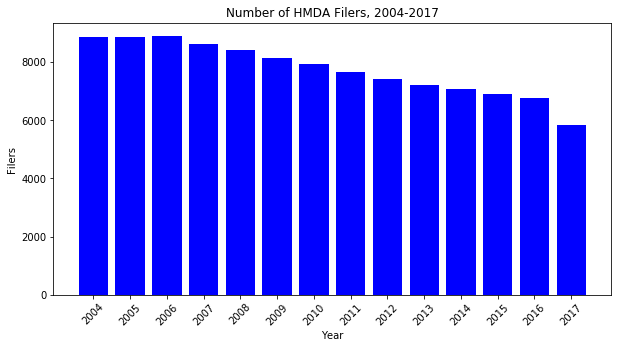

In [54]:
x = time_series_df()['Year'] #Uses the year column from the time_series data frame as x. 
y = time_series_df()['Filers'] #Uses the count of filers from the time_series data frame as y.
fig = plt.figure(figsize = (10,5)) #Adjusts the size of the bar chart. 
plt.bar(x, y, color = 'blue') #Creates a bar chart using x and y, setting the color as blue. 
plt.title("Number of HMDA Filers, 2004-2017") #Set title of the chart. 
plt.xlabel("Year") #Set x-axis label
plt.ylabel("Filers") #Set y-axis label.
plt.yticks=([])
plt.xticks(x, x, rotation='45') #Setting x-tick labels to 45 degrees. 
fig.savefig('analysis_output/charts/filer_count_time_series.png') #Saving output to a png file. 

A function may also be created to produce a bar chart. This function can be set with the default of producing a time-series of HMDA filers, but may be altered. The function would pass in a set of variables to first produce a dataframe with the time series function above, and then a bar chart. 

In [55]:
def bar_chart(data=time_series_df(),title="Number of HMDA Filers, 2004-2017",color='blue',
              xcolumn="Year",ycolumn="Filers"):
    """This function produces a bar chart.
    It passes in a two-column dataframe as "data," a title, a color for the bars."""
    x = data[xcolumn] #Uses the year column from the time_series data frame as x. 
    y = data[ycolumn] #Uses the count of filers from the time_series data frame as y.
    fig = plt.figure(figsize = (10,5)) #Adjusts the size of the bar chart. 
    plt.bar(x, y, color = color) #Creates a bar chart using x and y, setting the color as blue. 
    plt.title(title) #Set title of the chart. 
    plt.xlabel(xcolumn) #Set x-axis label
    plt.ylabel(ycolumn) #Set y-axis label. 
    plt.yticks=([])
    plt.xticks(x, x, rotation='45') #Setting x-tick labels to 45 degrees.  

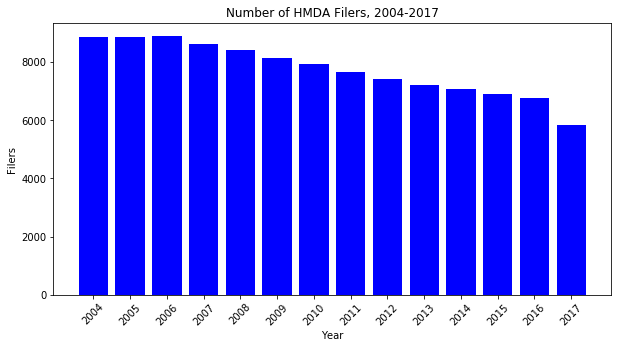

In [56]:
bar_chart()